# Model skrzyżowań złożonych w SUMO
## Wprowadzenie
W celu przeprowdzenia modelowania i symulacji skrzyżowania, wybrałyśmy dwa skrzyżowania:
* skrzyżowanie ulic Buszka, Reymonta i Piastowskiej w Krakowie, a dane pochodzą z artykułu: [link](https://ztp.krakow.pl/wp-content/uploads/2018/05/04_Analiza-ruchu.pdf)
* skrzyżowanie (??)


Legenda:
* **Buszka.netecfg** - plik konfiguracyjny dla Netedit, edytora sieci drogowych. Określa on pliki wejściowe, takie jak konfiguracja symulacji SUMO ("Buszka.sumocfg") i plik sieci drogowej ("BuszkaMain.net.xml"), używane do wczytywania danych do edycji. Ponadto, definiuje on pliki wyjściowe dla edytowanych danych, w tym plik świateł drogowych ("swiatla.tll.xml") i opcję wyświetlania nazw ulic.
* **Buszka.sumocfg** - plik konfiguracyjny dla SUMO. Definiuje wejścia, takie jak plik sieci drogowej ("BuszkaMain.net.xml") oraz pliki tras ruchu (np. "routes8_9.rou.xml" dla porannego szczytu). Dodatkowo, konfiguruje on wyjścia symulacji, określając nazwy plików dla danych o podróżach, podsumowań, kolejkach i danych FCD (Floating Car Data).
* **BuszkaMain.net.xml** - plik sieci drogowej (NET) dla SUMO. Definiuje on rzeczywistą strukturę sieci drogowej, obejmując takie elementy jak lokalizacja geograficzna, typy dróg, a także szczegółowe krawędzie (edges) i pasy (lanes), w tym wewnętrzne krawędzie skrzyżowań. Każda krawędź zawiera informacje o jej id, kierunku, nazwie, priorytecie, typie, kształcie i długości, co jest kluczowe dla symulacji ruchu pojazdów.
* 

## 1.Analiza danych z SUMO

W tej sekcji przeanalizujemy dane, które zwróciła nam symulacja.


--- Statystyki z pliku informacji o podróżach (tripinfo.xml) ---
Średni czas przejazdu: 57.96 s
Średnia długość trasy: 333.87 m
Średni czas postoju (oczekiwania na światłach): 22.04 s
Średnia liczba zatrzymań na pojazd: 0.71
Średnia prędkość wszystkich pojazdów: 24.92 km/h


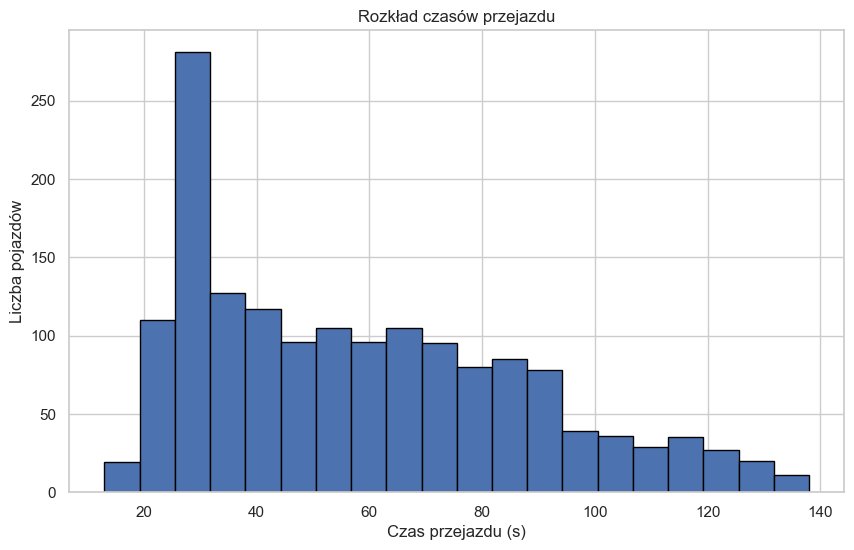

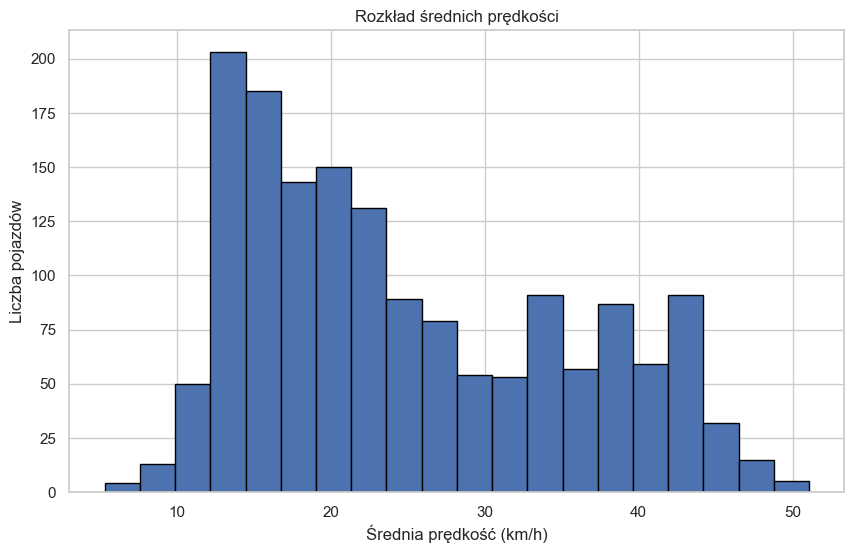

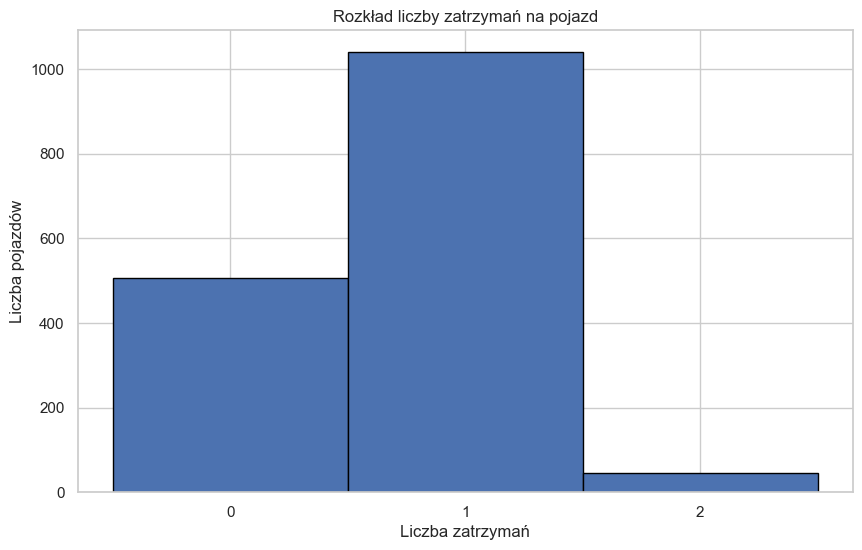


--- Statystyki z pliku podsumowania symulacji (summary.xml) ---
Łączna liczba pojazdów wpuszczonych do symulacji: 1613
Łączna liczba pojazdów, które dotarły do celu: 1591
Średnia prędkość w całej symulacji: 5.60 m/s = 20.18 km/h
Czas trwania symulacji: 3599.00 s

--- Statystyki z pliku kolejek (queues.xml) ---
Maksymalna długość kolejki (na dowolnym pasie w dowolnym czasie): 88.57 m
Średnia maksymalna długość kolejki (po wszystkich pasach): 28.42 m
Średni czas oczekiwania w kolejkach (średnia po wszystkich pasach i krokach czasowych): 25.19 s
Średnia liczba pojazdów w kolejkach (przybliżona): 4.54


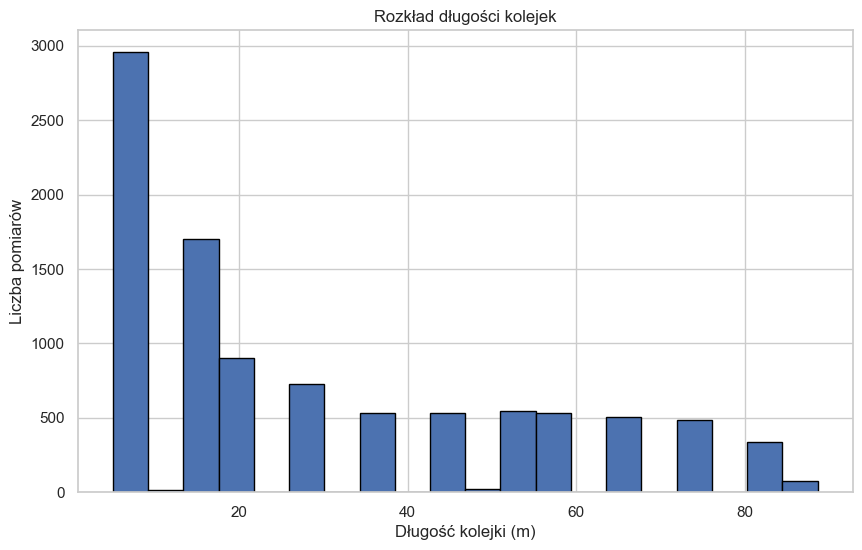

In [21]:
import xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt

def analizuj_tripinfo(sciezka_do_pliku):
    """Analizuje plik tripinfo.xml i wyświetla podstawowe statystyki."""
    drzewo_xml = ET.parse(sciezka_do_pliku)
    korzen_xml = drzewo_xml.getroot()
    czasy_przejazdu = []
    dlugosci_tras = []
    czasy_postoju = []
    srednie_predkosci = []
    liczby_zatrzyman = []

    for podroz in korzen_xml.findall('.//tripinfo'):
        czas_przejazdu_str = podroz.get('duration')
        dlugosc_trasy_str = podroz.get('routeLength')
        czas_postoju_str = podroz.get('waitingTime')
        liczba_zatrzyman_str = podroz.get('waitingCount')
        
        if czas_przejazdu_str is not None and dlugosc_trasy_str is not None and czas_postoju_str is not None:
            czas_przejazdu = float(czas_przejazdu_str)
            dlugosc_trasy = float(dlugosc_trasy_str)
            czas_postoju = float(czas_postoju_str)
            liczba_zatrzyman = int(liczba_zatrzyman_str)

            if czas_przejazdu != 0:
                srednia_predkosc = (dlugosc_trasy / czas_przejazdu) * 3.6  # m/s na km/h
            else:
                srednia_predkosc = None 

            if srednia_predkosc is not None:
                czasy_przejazdu.append(czas_przejazdu)
                dlugosci_tras.append(dlugosc_trasy)
                czasy_postoju.append(czas_postoju)
                srednie_predkosci.append(srednia_predkosc)
                liczby_zatrzyman.append(liczba_zatrzyman)

    if czasy_przejazdu:
        df_dane = pd.DataFrame({
            'czas_przejazdu': czasy_przejazdu,
            'dlugosc_trasy': dlugosci_tras,
            'czas_postoju': czasy_postoju,
            'srednia_predkosc': srednie_predkosci,
            'liczba_zatrzyman':liczby_zatrzyman 
        })

        print("\n--- Statystyki z pliku informacji o podróżach (tripinfo.xml) ---")
        print(f"Średni czas przejazdu: {df_dane['czas_przejazdu'].mean():.2f} s")
        print(f"Średnia długość trasy: {df_dane['dlugosc_trasy'].mean():.2f} m")
        print(f"Średni czas postoju (oczekiwania na światłach): {df_dane['czas_postoju'].mean():.2f} s")
        print(f"Średnia liczba zatrzymań na pojazd: {df_dane['liczba_zatrzyman'].mean():.2f}") 
        print(f"Średnia prędkość wszystkich pojazdów: {df_dane['srednia_predkosc'].mean():.2f} km/h")

        # Wizualizacja rozkładu czasów przejazdu
        plt.figure(figsize=(10, 6))
        plt.hist(df_dane['czas_przejazdu'], bins=20, edgecolor='black')
        plt.title('Rozkład czasów przejazdu')
        plt.xlabel('Czas przejazdu (s)')
        plt.ylabel('Liczba pojazdów')
        plt.grid(True)
        plt.show()

        # Wizualizacja rozkładu średnich prędkości
        plt.figure(figsize=(10, 6))
        plt.hist(df_dane['srednia_predkosc'], bins=20, edgecolor='black')
        plt.title('Rozkład średnich prędkości')
        plt.xlabel('Średnia prędkość (km/h)')
        plt.ylabel('Liczba pojazdów')
        plt.grid(True)
        plt.show()
        
        if df_dane['liczba_zatrzyman'].max() > 0: # Rysuj tylko jeśli są jakieś zatrzymania
            plt.figure(figsize=(10, 6))
            plt.hist(df_dane['liczba_zatrzyman'], bins=range(int(df_dane['liczba_zatrzyman'].max()) + 2), edgecolor='black', align='left')
            plt.title('Rozkład liczby zatrzymań na pojazd')
            plt.xlabel('Liczba zatrzymań')
            plt.ylabel('Liczba pojazdów')
            plt.xticks(range(int(df_dane['liczba_zatrzyman'].max()) + 1))
            plt.grid(True)
            plt.show()

    else:
        print("\n--- Brak danych o podróżach do analizy w pliku informacji o podróżach (tripinfo.xml) ---")


def analizuj_summary(sciezka_do_pliku):
    """Analizuje plik summary.xml i wyświetla podsumowanie symulacji."""
    drzewo_xml = ET.parse(sciezka_do_pliku)
    korzen_xml = drzewo_xml.getroot()

    lacznie_zaladowanych_pojazdow = 0
    lacznie_zakonczonych_podrozy = 0
    suma_srednich_predkosci = 0.0
    maks_czas_symulacji = 0.0
    liczba_krokow = 0

    for krok in korzen_xml.findall('.//step'):
        try:
            lacznie_zaladowanych_pojazdow = max(lacznie_zaladowanych_pojazdow, int(krok.get('loaded', 0)))
            lacznie_zakonczonych_podrozy = max(lacznie_zakonczonych_podrozy, int(krok.get('ended', 0)))
            suma_srednich_predkosci += float(krok.get('meanSpeed', 0))
            maks_czas_symulacji = max(maks_czas_symulacji, float(krok.get('time', 0)))
            liczba_krokow += 1
        except (ValueError, TypeError) as e:
            print(f"Błąd podczas parsowania kroku w pliku podsumowania symulacji (summary.xml): {e}")
            continue

    print("\n--- Statystyki z pliku podsumowania symulacji (summary.xml) ---")
    print(f"Łączna liczba pojazdów wpuszczonych do symulacji: {lacznie_zaladowanych_pojazdow}")
    print(f"Łączna liczba pojazdów, które dotarły do celu: {lacznie_zakonczonych_podrozy}")
    if liczba_krokow > 0:
        srednia_predkosc_calkowita = suma_srednich_predkosci / liczba_krokow
        print(f"Średnia prędkość w całej symulacji: {srednia_predkosc_calkowita:.2f} m/s = {srednia_predkosc_calkowita * 3.6:.2f} km/h")
    else:
        print("Brak kroków do obliczenia średniej prędkości.")
    print(f"Czas trwania symulacji: {maks_czas_symulacji:.2f} s")

def analizuj_queues(sciezka_do_pliku):
    """Analizuje plik queues.xml i wyświetla statystyki kolejek."""
    drzewo_xml = ET.parse(sciezka_do_pliku)
    korzen_xml = drzewo_xml.getroot()

    maksymalne_dlugosci_kolejek = {}
    calkowity_czas_oczekiwania = 0
    calkowita_liczba_pojazdow_w_kolejkach = 0
    liczba_pomiarow_pasow = {}
    wszystkie_dlugosci_kolejek = []

    for dane in korzen_xml.findall('.//data'):
        element_pasow = dane.find('./lanes')
        if element_pasow is not None:
            for pas in element_pasow.findall('./lane'):
                id_pasu = pas.get('id')
                dlugosc_kolejki = float(pas.get('queueing_length', 0))
                czas_oczekiwania = float(pas.get('queueing_time', 0))

                maksymalne_dlugosci_kolejek[id_pasu] = max(maksymalne_dlugosci_kolejek.get(id_pasu, 0), dlugosc_kolejki)
                if dlugosc_kolejki > 0: 
                    wszystkie_dlugosci_kolejek.append(dlugosc_kolejki)
                    
                calkowity_czas_oczekiwania += czas_oczekiwania
                # Przybliżona liczba pojazdów (zakładając średnią długość pojazdu ~6m)
                calkowita_liczba_pojazdow_w_kolejkach += (dlugosc_kolejki / 6.0) if dlugosc_kolejki > 0 else 0 
                liczba_pomiarow_pasow[id_pasu] = liczba_pomiarow_pasow.get(id_pasu, 0) + 1

    if maksymalne_dlugosci_kolejek:
        print("\n--- Statystyki z pliku kolejek (queues.xml) ---")
        maksymalna_calkowita_dlugosc_kolejki = max(maksymalne_dlugosci_kolejek.values()) if maksymalne_dlugosci_kolejek.values() else 0
        srednia_maksymalna_dlugosc_kolejki = sum(maksymalne_dlugosci_kolejek.values()) / len(maksymalne_dlugosci_kolejek) if maksymalne_dlugosci_kolejek else 0
        print(f"Maksymalna długość kolejki (na dowolnym pasie w dowolnym czasie): {maksymalna_calkowita_dlugosc_kolejki:.2f} m")
        print(f"Średnia maksymalna długość kolejki (po wszystkich pasach): {srednia_maksymalna_dlugosc_kolejki:.2f} m")

    suma_pomiarow = sum(liczba_pomiarow_pasow.values())
    if calkowity_czas_oczekiwania > 0 and suma_pomiarow > 0:
        sredni_czas_oczekiwania_w_kolejkach = calkowity_czas_oczekiwania / suma_pomiarow
        print(f"Średni czas oczekiwania w kolejkach (średnia po wszystkich pasach i krokach czasowych): {sredni_czas_oczekiwania_w_kolejkach:.2f} s")

    if calkowita_liczba_pojazdow_w_kolejkach > 0 and suma_pomiarow > 0:
        srednia_liczba_pojazdow_w_kolejkach = calkowita_liczba_pojazdow_w_kolejkach / suma_pomiarow
        print(f"Średnia liczba pojazdów w kolejkach (przybliżona): {srednia_liczba_pojazdow_w_kolejkach:.2f}")
    elif maksymalne_dlugosci_kolejek:
        print("Brak danych o czasie oczekiwania lub długości kolejek do obliczenia średniej.")
    else:
        print("\n--- Brak danych o kolejkach w pliku kolejek (queues.xml) ---")
    
    if wszystkie_dlugosci_kolejek:
        plt.figure(figsize=(10, 6))
        plt.hist(wszystkie_dlugosci_kolejek, bins=20, edgecolor='black')
        plt.title('Rozkład długości kolejek')
        plt.xlabel('Długość kolejki (m)')
        plt.ylabel('Liczba pomiarów')
        plt.grid(True)
        plt.show()
    else:
        print("Brak danych o długości kolejek do wizualizacji.")

def main():
    
    nazwa_pliku_tripinfo = 'tripinfo_rano.xml'
    nazwa_pliku_summary = 'summary_rano.xml'
    nazwa_pliku_queues = 'queues_rano.xml'

    analizuj_tripinfo(nazwa_pliku_tripinfo)
    analizuj_summary(nazwa_pliku_summary)
    analizuj_queues(nazwa_pliku_queues)

if __name__ == "__main__":
    main()

## 2. Porównanie danych z SUMO z referencyjnymi danymi

W tej sekcji porównamy dane z SUMO z danymi z artykułów.

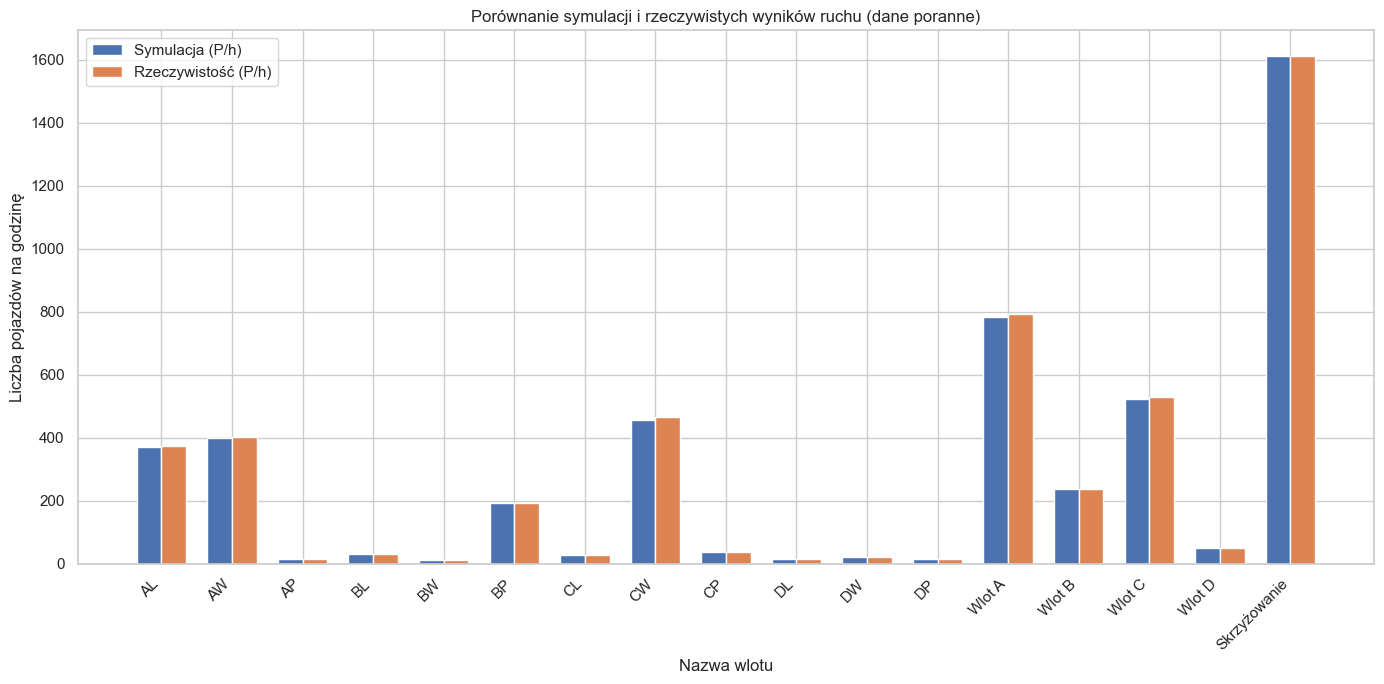


========================== PORÓWNANIE NATĘŻENIA RUCHU ==========================
================================ SZCZYT PORANNY ================================


                                      P/H                                       
--------------------------------------------------------------------------------
     Relacja  Symulacja  Referencja  Różnica bezwzględna  Różnica procentowa
          AL      370.0       375.0                 -5.0                -1.3
          AP       15.0        15.0                  0.0                 0.0
          AW      400.0       404.0                 -4.0                -1.0
          BL       32.0        32.0                  0.0                 0.0
          BP      193.0       194.0                 -1.0                -0.5
          BW       13.0        13.0                  0.0                 0.0
          CL       29.0        29.0                  0.0                 0.0
          CP       37.0        37.0                  0.0 

In [22]:
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

def przetworz_dane_fcd(sciezka_pliku_fcd):
    """Przetwarza plik XML FCD do śledzenia ruchu pojazdów."""
    drzewo = ET.parse(sciezka_pliku_fcd)
    korzen = drzewo.getroot()
    
    sciezki_pojazdow = {}  # {id_pojazdu: [lista pasów]}
    pasy_wjazdowe = {}      # {id_pojazdu: pas_wjazdowy}
    pasy_wyjazdowe = {}     # {id_pojazdu: pas_wyjazdowy}
    
    for krok_czasowy in korzen.findall('timestep'):
        czas = float(krok_czasowy.get('time'))
        for pojazd in krok_czasowy.findall('vehicle'):
            id_pojazdu = pojazd.get('id')
            pas = pojazd.get('lane')
            
            if id_pojazdu not in sciezki_pojazdow:
                sciezki_pojazdow[id_pojazdu] = []
            
            if not sciezki_pojazdow[id_pojazdu] or sciezki_pojazdow[id_pojazdu][-1] != pas:
                sciezki_pojazdow[id_pojazdu].append(pas)
            
            if id_pojazdu not in pasy_wjazdowe:
                pasy_wjazdowe[id_pojazdu] = pas
    
    for id_pojazdu, pasy in sciezki_pojazdow.items():
        if pasy:
            pasy_wyjazdowe[id_pojazdu] = pasy[-1]
    
    return pasy_wjazdowe, pasy_wyjazdowe, sciezki_pojazdow

def okresl_relacje(pas_wjazdowy, pas_wyjazdowy):
    """Mapuje pasy wjazdowe i wyjazdowe na kody relacji."""
    # Mapa podejść
    mapa_podejsc = {
        'Ai': 'A',
        'Bi': 'B',
        'Ci': 'C',
        'Di': 'D'
    }
    
    # Mapa kierunków ruchu
    mapa_kierunkow = {
        # Z A (Piastowska Północ)
        ('Ai', 'Bo'): 'L',  # Lewo do B (Reymonta Wschód)
        ('Ai', 'Co'): 'W',  # Prost do C (Piastowska Południe)
        ('Ai', 'Do'): 'P',  # Prawo do D (Buszka Zachód)
        
        # Z B (Reymonta Wschód)
        ('Bi', 'Ao'): 'P',  # Prawo do A (Piastowska Północ)
        ('Bi', 'Co'): 'L',  # Lewo do C (Piastowska Południe)
        ('Bi', 'Do'): 'W',  # Prost do D (Buszka Zachód)
        
        # Z C (Piastowska Południe)
        ('Ci', 'Ao'): 'W',  # Prost do A (Piastowska Północ)
        ('Ci', 'Bo'): 'P',  # Prawo do B (Reymonta Wschód)
        ('Ci', 'Do'): 'L',  # Lewo do D (Buszka Zachód)
        
        # Z D (Buszka Zachód)
        ('Di', 'Ao'): 'L',  # Lewo do A (Piastowska Północ)
        ('Di', 'Bo'): 'W',  # Prost do B (Reymonta Wschód)
        ('Di', 'Co'): 'P',  # Prawo do C (Piastowska Południe)
    }
    
    podejscie_wjazd = pas_wjazdowy.split('_')[0]
    podejscie_wyjazd = pas_wyjazdowy.split('_')[0]
    
    klucz_relacji = (podejscie_wjazd, podejscie_wyjazd)
    if klucz_relacji in mapa_kierunkow:
        podejscie = mapa_podejsc.get(podejscie_wjazd, '?')
        kierunek = mapa_kierunkow[klucz_relacji]
        return f"{podejscie}{kierunek}"
    
    return "Nieznane"

def oblicz_natezenia_ruchu(pasy_wjazdowe, pasy_wyjazdowe, czas_symulacji_sekundy):
    """Oblicza natężenia ruchu dla każdej relacji."""
    liczniki_relacji = defaultdict(int)

    for id_pojazdu, pas_wjazdowy in pasy_wjazdowe.items():
        if id_pojazdu in pasy_wyjazdowe:
            pas_wyjazdowy = pasy_wyjazdowe[id_pojazdu]
            relacja = okresl_relacje(pas_wjazdowy, pas_wyjazdowy)
            liczniki_relacji[relacja] += 1

    godziny = czas_symulacji_sekundy / 3600
    natezenia_relacji = {relacja: liczba / godziny for relacja, liczba in liczniki_relacji.items()}

    natezenia_pce = natezenia_relacji.copy()

    sumy_podejsc = defaultdict(int)
    for relacja, liczba in liczniki_relacji.items():
        if len(relacja) >= 1:
            podejscie = relacja[0]  # Pierwszy znak to podejście (A, B, C, D)
            sumy_podejsc[f"Wlot {podejscie}"] += liczba

    sumy_natezen_podejsc = {podejscie: suma / godziny for podejscie, suma in sumy_podejsc.items()}
    sumy_pce_podejsc = sumy_natezen_podejsc.copy()

    suma_calkowita = sum(liczniki_relacji.values())
    natezenie_calkowite = suma_calkowita / godziny
    pce_calkowite = natezenie_calkowite  # Zakładamy PCE=1 dla wszystkich pojazdów

    return liczniki_relacji, natezenia_relacji, natezenia_pce, sumy_natezen_podejsc, sumy_pce_podejsc, natezenie_calkowite, pce_calkowite

def utworz_dataframe_referencyjny():
    """Tworzy DataFrame z wartościami referencyjnymi."""
    
    # Dane referencyjne dla godziny szczytu porannego (8:00-9:00)
    dane_poranne = {
        'AL': {'P/h': 375, 'E/h': 374.5},
        'AW': {'P/h': 404, 'E/h': 410},
        'AP': {'P/h': 15, 'E/h': 15},
        
        'BL': {'P/h': 32, 'E/h': 32.5},
        'BW': {'P/h': 13, 'E/h': 12.5},
        'BP': {'P/h': 194, 'E/h': 196},
        
        'CL': {'P/h': 29, 'E/h': 28.5},
        'CW': {'P/h': 465, 'E/h': 468},
        'CP': {'P/h': 37, 'E/h': 37},
        
        'DL': {'P/h': 14, 'E/h': 14},
        'DW': {'P/h': 20, 'E/h': 17.5},
        'DP': {'P/h': 15, 'E/h': 12},
        
        'Wlot A': {'P/h': 794, 'E/h': 799.5},
        
        'Wlot B': {'P/h': 239, 'E/h': 241},
        
        'Wlot C': {'P/h': 531, 'E/h': 533.5},
        
        'Wlot D': {'P/h': 49, 'E/h': 43.5},
        
        'Skrzyżowanie': {'P/h': 1613, 'E/h': 1617.5}
    }
    
    # Dane referencyjne dla godziny szczytu popołudniowego (15:45-16:45)
    dane_popoludniowe = {
        'AL': {'P/h': 311 , 'E/h': 313},
        'AW': {'P/h': 520, 'E/h': 527},
        'AP': {'P/h': 25, 'E/h': 21},
        
        'BL': {'P/h': 48, 'E/h': 48},
        'BW': {'P/h': 42, 'E/h': 31},
        'BP': {'P/h': 314, 'E/h': 316},
        
        'CL': {'P/h': 18, 'E/h': 16},
        'CW': {'P/h': 462, 'E/h': 458},
        'CP': {'P/h': 49, 'E/h': 46},
        
        'DL': {'P/h': 16, 'E/h': 16},
        'DW': {'P/h': 18, 'E/h': 17},
        'DP': {'P/h': 24, 'E/h': 19.5},
        
        'Wlot A': {'P/h':856 , 'E/h': 861},
        
        'Wlot B': {'P/h': 404, 'E/h':395 },
        
        'Wlot C': {'P/h':529 , 'E/h': 520},
        
        'Wlot D': {'P/h': 58, 'E/h': 52.5},
        
        'Skrzyżowanie': {'P/h': 1847, 'E/h': 1828.5}
    }
    
    # Połączenie danych w DataFrame
    df_poranny = pd.DataFrame([(k, 'poranny', 'P/h', v['P/h']) for k, v in dane_poranne.items()] + 
                            [(k, 'poranny', 'E/h', v['E/h']) for k, v in dane_poranne.items()],
                          columns=['Relacja', 'Szczyt', 'Metryka', 'Wartość'])
    
    df_popoludniowy = pd.DataFrame([(k, 'popołudniowy', 'P/h', v['P/h']) for k, v in dane_popoludniowe.items()] + 
                              [(k, 'popołudniowy', 'E/h', v['E/h']) for k, v in dane_popoludniowe.items()],
                            columns=['Relacja', 'Szczyt', 'Metryka', 'Wartość'])
    
    df = pd.concat([df_poranny, df_popoludniowy])

    dane_dict = {
        'poranny': dane_poranne,
        'popołudniowy': dane_popoludniowe
    }

    return df, dane_dict


def porownaj_z_referencjami(wyniki_symulacji, dane_referencyjne, dane_referencyjne_dict, okres_szczytu):
    """Porównuje wyniki symulacji z danymi referencyjnymi i oblicza metryki."""
    # Przygotowanie danych symulacyjnych
    dane_symulacji = []
    for relacja, natezenie in wyniki_symulacji['P/h'].items():
        dane_symulacji.append({
            'Relacja': relacja,
            'Szczyt': okres_szczytu,
            'Metryka': 'P/h',
            'Symulacja': natezenie
        })
    
    for relacja, natezenie_pce in wyniki_symulacji['E/h'].items():
        dane_symulacji.append({
            'Relacja': relacja,
            'Szczyt': okres_szczytu,
            'Metryka': 'E/h',
            'Symulacja': natezenie_pce
        })
    
    df_symulacja = pd.DataFrame(dane_symulacji)
    
    df_referencja = dane_referencyjne[dane_referencyjne['Szczyt'] == okres_szczytu].copy()
    
    df_porownanie = pd.merge(df_symulacja, df_referencja, on=['Relacja', 'Szczyt', 'Metryka'], how='outer')
    
    df_porownanie = df_porownanie.rename(columns={'Wartość': 'Referencja'})
    
    df_porownanie['Różnica bezwzględna'] = df_porownanie['Symulacja'] - df_porownanie['Referencja']
    df_porownanie['Różnica procentowa'] = (df_porownanie['Różnica bezwzględna'] / df_porownanie['Referencja']) * 100
    
    df_poprawne = df_porownanie.dropna(subset=['Symulacja', 'Referencja'])
    
    rmse = np.sqrt(np.mean((df_poprawne['Symulacja'] - df_poprawne['Referencja']) ** 2))
    mape = np.mean(np.abs(df_poprawne['Różnica procentowa']))
    mae = np.mean(np.abs(df_poprawne['Różnica bezwzględna']))
    
    metryki = {
        'RMSE': rmse,
        'MAPE': mape,
        'MAE': mae
    }
    wykres_porownanie(wyniki_symulacji, dane_referencyjne_dict[okres_szczytu])
    return df_porownanie, metryki


def wykres_porownanie(wyniki_symulacji, dane_referencyjne):
    # Przygotowanie danych do wykresu
    nazwy_wlotow = list( dane_referencyjne.keys())
    rzeczywistosc = [dane['P/h'] for dane in  dane_referencyjne.values()]  # Używam 'P/h' dla rzeczywistości
    symulacja = [wyniki_symulacji['P/h'].get(klucz, 0) for klucz in nazwy_wlotow] # Pobieram 'P/h' z wyników symulacji

    # Ustawienie szerokości kolumn i pozycji grup
    szerokosc_kolumny = 0.35
    pozycja_symulacji = np.arange(len(nazwy_wlotow))
    pozycja_rzeczywistosci = [pos + szerokosc_kolumny for pos in pozycja_symulacji]

    fig, ax = plt.subplots(figsize=(14, 7))

    slupki_symulacji = ax.bar(pozycja_symulacji, symulacja, szerokosc_kolumny, label='Symulacja (P/h)')
    slupki_rzeczywistosci = ax.bar(pozycja_rzeczywistosci, rzeczywistosc, szerokosc_kolumny, label='Rzeczywistość (P/h)')

    ax.set_ylabel('Liczba pojazdów na godzinę')
    ax.set_xlabel('Nazwa wlotu')
    ax.set_title('Porównanie symulacji i rzeczywistych wyników ruchu (dane poranne)')
    ax.set_xticks(pozycja_symulacji + szerokosc_kolumny / 2)
    ax.set_xticklabels(nazwy_wlotow, rotation=45, ha='right')
    ax.legend()

    # Poprawienie układu, aby etykiety się nie nakładały
    plt.tight_layout()
    plt.show()


def main(sciezka_pliku_fcd, czas_symulacji_sekundy, okres_szczytu):
    pasy_wjazdowe, pasy_wyjazdowe, sciezki_pojazdow = przetworz_dane_fcd(sciezka_pliku_fcd)
    
    liczniki_relacji, natezenia_relacji, natezenia_pce, sumy_natezen_podejsc, sumy_pce_podejsc, natezenie_calkowite, pce_calkowite = oblicz_natezenia_ruchu(
        pasy_wjazdowe, pasy_wyjazdowe, czas_symulacji_sekundy)
    
    wyniki_symulacji = {
        'P/h': {**natezenia_relacji, **sumy_natezen_podejsc, 'Skrzyżowanie': natezenie_calkowite},
        'E/h': {**natezenia_pce, **sumy_pce_podejsc, 'Skrzyżowanie': pce_calkowite}
    }
    
    # Tworzenie DataFrame z danymi referencyjnymi
    dane_referencyjne_df, dane_referencyjne_dict = utworz_dataframe_referencyjny()
    
    # Porównanie z danymi referencyjnymi
    df_porownanie, metryki = porownaj_z_referencjami(wyniki_symulacji, dane_referencyjne_df, dane_referencyjne_dict, okres_szczytu)
    
    # Wyświetlanie wyników w formie ładnej tabeli
    print(f"\n{' PORÓWNANIE NATĘŻENIA RUCHU ':=^80}")
    print(f"{' SZCZYT ' + okres_szczytu.upper() + ' ':=^80}\n")
    
    # Formatowanie DataFrame do wyświetlenia
    pd.set_option('display.max_rows', None)
    pd.set_option('display.width', 120)
    pd.set_option('display.float_format', '{:.1f}'.format)
    
    # Podział na metryki
    for metryka in ['P/h', 'E/h']:
        df_metryka = df_porownanie[df_porownanie['Metryka'] == metryka].sort_values('Relacja')
        print(f"\n{metryka.upper():^80}")
        print("-"*80)
        print(df_metryka[['Relacja', 'Symulacja', 'Referencja', 'Różnica bezwzględna', 'Różnica procentowa']].to_string(index=False))
    
    # Wyświetlanie metryk wydajności
    print("\n\n{' METRYKI JAKOŚCI ':=^80}")
    print(f"Średni błąd kwadratowy (RMSE): {metryki['RMSE']:.1f}")
    print(f"Średni błąd procentowy (MAPE): {metryki['MAPE']:.1f}%")
    print(f"Średni błąd bezwzględny (MAE): {metryki['MAE']:.1f}")
    
    # Zapis wyników do pliku CSV
    df_porownanie.to_csv(f'porownanie_ruchu_{okres_szczytu}.csv', index=False, encoding='utf-8-sig')
    
  

if __name__ == "__main__":
    sciezka_pliku_fcd = "fcd_rano.xml"
    
    czas_symulacji_sekundy = 3600  # 1 godzina
    
    okres_szczytu = "poranny"  # Zmień na 'popołudniowy' dla szczytu popołudniowego
    
    main(sciezka_pliku_fcd, czas_symulacji_sekundy, okres_szczytu)

## 3. Metryki

W tej sekcji przeanalizujemy zgodność naszych wyników z SUMO z rzeczywistymi wynikami. Naszym punktem odniesienia będą: 
* D – średnie straty czasu przypadające na pojazd na pasie ruchu [s/P],
* Z – wskaźnik zatrzymań wyrażający średnia liczbę zatrzymań przypadających na
pojazd [-],
* Lk – zasięg kwantyla 95% kolejki maksymalnej (zalecana długość odcinka
akumulacji na pasie ruchu) [m],

In [27]:
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap


# --- GLOBALNE DANE REFERENCYJNE DLA D, Z, LK ---
reference_metrics_d_z_lk = {
    'AWP': {'D': 10.0, 'Z': 0.470, 'Lk': 75.0},
    'AL': {'D': 110.0, 'Z': 1.551, 'Lk': 175.0},
    
    'BLW': {'D': 44.2, 'Z': 0.959, 'Lk': 38.0},
    'BP': {'D': 18.8, 'Z': 0.603, 'Lk': 50.0},
    
    'CLWP': {'D': 227.9, 'Z': 2.559, 'Lk': 419.0},
    'DLWP': {'D': 950.0, 'Z': 6.557, 'Lk': 475.0},
}

# --- Funkcje przetwarzające pliki SUMO ---

def determine_relation(entry_lane, exit_lane):
    """
    Mapuje pasy wjazdowe i wyjazdowe na kody relacji, uwzględniając relacje złożone
    z Twojej tabeli referencyjnej (AWP, BLW, CLWP, DLWP).
    """
    
    # Mapa podejść (wlotów)
    approach_map = {
        'Ai': 'A', 'Bi': 'B', 'Ci': 'C', 'Di': 'D'
    }
    
    # Mapa kierunków ruchu bazująca na krawędziach wyjazdowych (output edges)
    direction_map = {
        ('Ai', 'Bo'): 'L',  # A -> B (Lewo)
        ('Ai', 'Co'): 'W',  # A -> C (Prosto)
        ('Ai', 'Do'): 'P',  # A -> D (Prawo)
        
        ('Bi', 'Ao'): 'P',  # B -> A (Prawo)
        ('Bi', 'Co'): 'L',  # B -> C (Lewo)
        ('Bi', 'Do'): 'W',  # B -> D (Prosto)
        
        ('Ci', 'Ao'): 'W',  # C -> A (Prosto)
        ('Ci', 'Bo'): 'P',  # C -> B (Prawo)
        ('Ci', 'Do'): 'L',  # C -> D (Lewo)
        
        ('Di', 'Ao'): 'L',  # D -> A (Lewo)
        ('Di', 'Bo'): 'W',  # D -> B (Prosto)
        ('Di', 'Co'): 'P',  # D -> C (Prawo)
    }
    
    # Ekstrakcja prefixu krawędzi (np. 'Ai_0' -> 'Ai')
    entry_edge_prefix = entry_lane.split('_')[0]
    exit_edge_prefix = exit_lane.split('_')[0]
    
    relation_key = (entry_edge_prefix, exit_edge_prefix)
    
    if relation_key in direction_map:
        approach_letter = approach_map.get(entry_edge_prefix, '?')
        direction_letter = direction_map[relation_key]
        
        # AWP = AW + AP
        if approach_letter == 'A' and (direction_letter == 'W' or direction_letter == 'P'):
            return 'AWP'
        # BLW = BL + BW
        if approach_letter == 'B' and (direction_letter == 'L' or direction_letter == 'W'):
            return 'BLW'
        # CLWP = CL + CW + CP
        if approach_letter == 'C' and (direction_letter == 'L' or direction_letter == 'W' or direction_letter == 'P'):
            return 'CLWP'
        # DLWP = DL + DW + DP
        if approach_letter == 'D' and (direction_letter == 'L' or direction_letter == 'W' or direction_letter == 'P'):
            return 'DLWP'
        
        return f"{approach_letter}{direction_letter}"
    
    return "Nieznane"


def analyze_tripinfo_for_metrics(tripinfo_file_path):
    """
    Analizuje plik tripinfo.xml w celu ekstrakcji średnich strat czasu (D)
    i wskaźników zatrzymań (Z) per relacja.
    
    Zwraca DataFrame z 'id_pojazdu', 'relacja_pojazdu', 'straty_czasu', 'liczba_zatrzyman'.
    """
    tree = ET.parse(tripinfo_file_path)
    root = tree.getroot()
    data = []
    for tripinfo in root.findall('.//tripinfo'):
        vehicle_id = tripinfo.get('id')
        # Zmieniamy z 'waitingTime' na 'timeLoss' dla metryki D
        time_loss = float(tripinfo.get('timeLoss', 0.0))
        waiting_count = int(tripinfo.get('waitingCount', 0))
        
        depart_lane = tripinfo.get('departLane', 'NieznanyPas')
        arrival_lane = tripinfo.get('arrivalLane', 'NieznanyPas')
        
        relation = determine_relation(depart_lane, arrival_lane)
        
        data.append({
            'id_pojazdu': vehicle_id,
            'relacja_pojazdu': relation,
            'straty_czasu': time_loss, # Zmieniona nazwa kolumny
            'liczba_zatrzyman': waiting_count
        })
    
    df_tripinfo = pd.DataFrame(data)
    return df_tripinfo

def analyze_queues_for_lk(queues_file_path):
    """
    Analizuje plik queues.xml i zwraca słownik zawierający listę
    wszystkich długości kolejek per relacja, dla obliczenia Lk (95% kwantyl).
    
    Dostosowane do prostszego formatu ID pasów w pliku queues_rano.xml
    """
    tree = ET.parse(queues_file_path)
    root = tree.getroot()

    # MAPOWANIE ID PASÓW Z PLIKU QUEUES NA RELACJE RUCHOWE
    # Dostosowane do rzeczywistych ID pasów z pliku queues_rano.xml
    lane_to_relation_map = {
        # Wlot A
        'Ai_0': 'AL',   # Pas dla lewoskrętu
        'Ai_1': 'AWP',  # Pas dla prosto/prawo
        'Ai_2': 'AWP',  # Dodatkowy pas dla prosto/prawo, jeśli istnieje

        # Wlot B
        'Bi_0': 'BLW',  # Pas dla lewo/prosto
        'Bi_1': 'BP',   # Pas dla prawo

        # Wlot C
        'Ci_0': 'CLWP', # Pas dla lewo/prosto/prawo
        'Ci_1': 'CLWP', # Dodatkowy pas, jeśli istnieje
        'Ci_2': 'CLWP', # Dodatkowy pas, jeśli istnieje

        # Wlot D
        'Di_0': 'DLWP', # Pas dla lewo/prosto/prawo
        'Di_1': 'DLWP', # Dodatkowy pas, jeśli istnieje
        'Di_2': 'DLWP', # Dodatkowy pas, jeśli istnieje
    }

    all_queue_lengths_per_relation = defaultdict(list)
    
    for data_step in root.findall('.//data'):
        lanes_element = data_step.find('./lanes')
        if lanes_element is not None:
            for lane_element in lanes_element.findall('./lane'):
                lane_id = lane_element.get('id')
                
                # Używamy queueing_length_experimental, ponieważ oferuje bardziej dokładne dane
                # o długości kolejki (uwzględnia również pojazdy zbliżające się do zatrzymania)
                queueing_length = float(lane_element.get('queueing_length_experimental', 0))
                
                # Przypisanie długości kolejki do relacji na podstawie mapowania
                if lane_id in lane_to_relation_map:
                    relation = lane_to_relation_map[lane_id]
                    all_queue_lengths_per_relation[relation].append(queueing_length)
                else:
                    # Można odkomentować poniższą linię do celów debugowania
                    # print(f"Ostrzeżenie: Pas {lane_id} nie ma zdefiniowanego mapowania na relację.")
                    pass
    
    # Obliczanie 95% kwantyla dla każdej relacji
    lk_per_relation = {}
    for relation, queue_lengths in all_queue_lengths_per_relation.items():
        if queue_lengths: # Upewnij się, że są dane do obliczeń
            lk_per_relation[relation] = np.percentile(queue_lengths, 95)
        else:
            lk_per_relation[relation] = np.nan # Brak danych dla tej relacji
            
    return lk_per_relation




=== ROZPOCZĘCIE ANALIZY DODATKOWYCH METRYK (D, Z, Lk) ===

                 PORÓWNANIE METRYK SKRZYŻOWANIA: SYMULACJA vs REFERENCJA                  

--- Średnia strata czasu [s] (D) ---
Relacja Symulacja Referencja Różnica Różnica %
     AL     60.13     110.00  -49.87   -45.34%
    AWP     12.60      10.00    2.60    26.04%
    BLW     35.59      44.20   -8.61   -19.49%
     BP     18.36      18.80   -0.44    -2.35%
   CLWP     35.02     227.90 -192.88   -84.63%
   DLWP     35.11     950.00 -914.89   -96.30%

--- Wskaźnik zatrzymań (Z) ---
Relacja Symulacja Referencja Różnica Różnica %
     AL     1.057      1.551  -0.494   -31.87%
    AWP     0.373      0.470  -0.097   -20.66%
    BLW     0.822      0.959  -0.137   -14.26%
     BP     0.591      0.603  -0.012    -2.04%
   CLWP     0.760      2.559  -1.799   -70.30%
   DLWP     0.776      6.557  -5.781   -88.17%

--- Długość kolejki [m] (Lk) ---
Relacja Symulacja Referencja Różnica Różnica %
     AL     28.78     175.00 -146.22   -

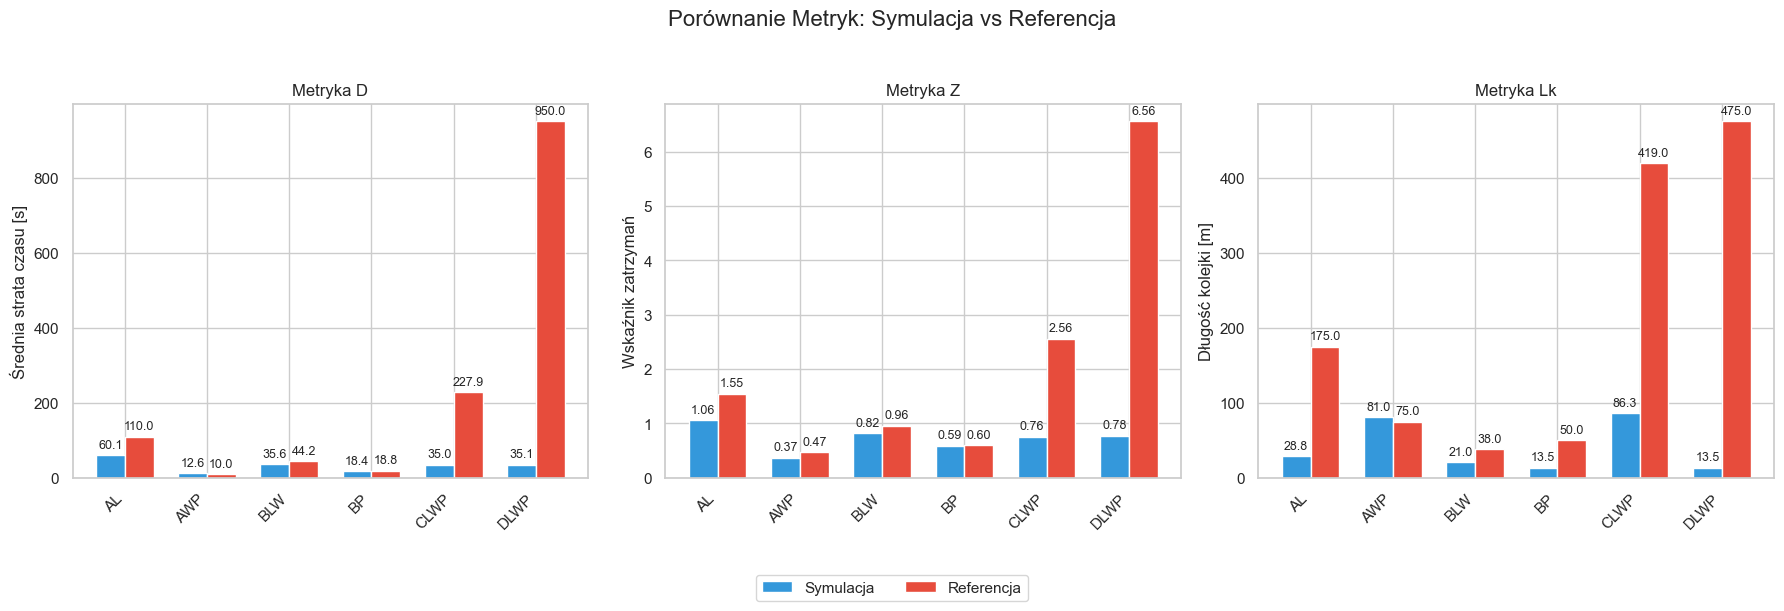

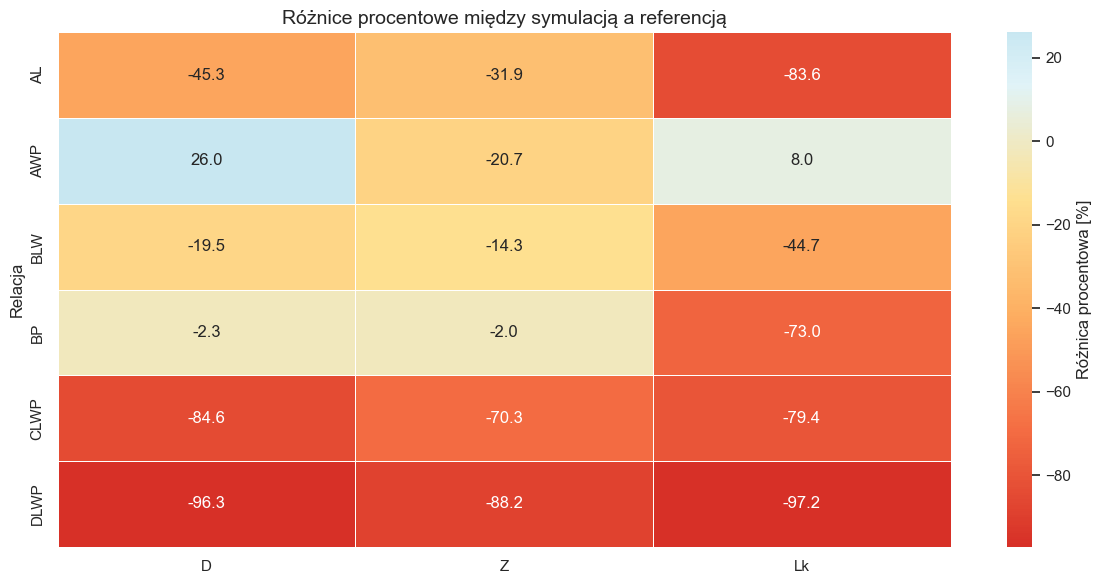


=== ZAKOŃCZENIE ANALIZY DODATKOWYCH METRYK ===


In [29]:
def compare_and_visualize_metrics_improved(df_tripinfo_sumo, lk_per_relation_sumo, reference_metrics_d_z_lk):
    """
    Porównuje i wizualizuje metryki D, Z, Lk per relacja z danymi referencyjnymi.
    Wersja ulepszona z bardziej czytelnymi tabelami i atrakcyjnymi wizualizacjami.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    from matplotlib.colors import LinearSegmentedColormap
    
    # Ustawienia stylu dla wykresów
    sns.set_theme(style="whitegrid")
    plt.rcParams.update({'font.size': 12, 'figure.figsize': (14, 8)})
    
    # 1. Agregacja danych D i Z z tripinfo.xml per relacja
    grouped_tripinfo = df_tripinfo_sumo[df_tripinfo_sumo['relacja_pojazdu'] != 'Nieznane'].groupby('relacja_pojazdu').agg(
        D_sym=('straty_czasu', 'mean'),
        Z_sym=('liczba_zatrzyman', 'mean')
    ).reset_index().rename(columns={'relacja_pojazdu': 'Relacja'})
    
    # 2. Przygotowanie danych Lk z queues.xml
    df_lk_sim = pd.DataFrame(lk_per_relation_sumo.items(), columns=['Relacja', 'Lk_sym'])
    
    # 3. Połączenie wszystkich metryk symulacji
    df_sim_metrics = pd.merge(grouped_tripinfo, df_lk_sim, on='Relacja', how='outer')
    
    # 4. Przygotowanie danych referencyjnych
    relations = []
    ref_d = []
    ref_z = []
    ref_lk = []
    
    for relation, metrics in reference_metrics_d_z_lk.items():
        relations.append(relation)
        ref_d.append(metrics['D'])
        ref_z.append(metrics['Z'])
        ref_lk.append(metrics['Lk'])
    
    df_ref = pd.DataFrame({
        'Relacja': relations,
        'D_ref': ref_d,
        'Z_ref': ref_z,
        'Lk_ref': ref_lk
    })
    
    # 5. Połączenie danych symulacji z referencyjnymi
    df_complete = pd.merge(df_sim_metrics, df_ref, on='Relacja', how='outer')
    
    # 6. Obliczanie różnic i procentów
    for metric in ['D', 'Z', 'Lk']:
        df_complete[f'{metric}_diff'] = df_complete[f'{metric}_sym'] - df_complete[f'{metric}_ref']
        df_complete[f'{metric}_diff_pct'] = (df_complete[f'{metric}_diff'] / df_complete[f'{metric}_ref']) * 100
    
    # 7. Tworzenie kolorowanej tabeli dla każdej metryki
    print("\n" + "="*90)
    print(f"{'PORÓWNANIE METRYK SKRZYŻOWANIA: SYMULACJA vs REFERENCJA':^90}")
    print("="*90)
    
    for metric_name, full_name in [('D', 'Średnia strata czasu [s]'), 
                                  ('Z', 'Wskaźnik zatrzymań'),
                                  ('Lk', 'Długość kolejki [m]')]:
        
        # Przygotowanie danych do tabeli dla konkretnej metryki
        metric_data = df_complete[['Relacja', f'{metric_name}_sym', f'{metric_name}_ref', 
                                 f'{metric_name}_diff', f'{metric_name}_diff_pct']].copy()
        metric_data.columns = ['Relacja', 'Symulacja', 'Referencja', 'Różnica', 'Różnica %']
        
        # Formatowanie danych
        if metric_name == 'Z':
            format_dict = {'Symulacja': '{:.3f}', 'Referencja': '{:.3f}', 
                         'Różnica': '{:.3f}', 'Różnica %': '{:.2f}%'}
        else:
            format_dict = {'Symulacja': '{:.2f}', 'Referencja': '{:.2f}', 
                         'Różnica': '{:.2f}', 'Różnica %': '{:.2f}%'}
        
        for col, format_str in format_dict.items():
            metric_data[col] = metric_data[col].apply(
                lambda x: format_str.format(x) if pd.notnull(x) else "N/A")
        
        # Wyświetlenie tabeli z tytułem
        print(f"\n--- {full_name} ({metric_name}) ---")
        print(metric_data.to_string(index=False))
    
    # 8. Obliczanie metryk jakości (RMSE, MAPE, MAE)
    metrics_quality = {}
    for metric_type in ['D', 'Z', 'Lk']:
        df_valid = df_complete.dropna(subset=[f'{metric_type}_sym', f'{metric_type}_ref'])
        if not df_valid.empty:
            rmse = np.sqrt(np.mean((df_valid[f'{metric_type}_sym'] - df_valid[f'{metric_type}_ref']) ** 2))
            mae = np.mean(np.abs(df_valid[f'{metric_type}_diff']))
            mape = np.mean(np.abs(df_valid[f'{metric_type}_diff_pct']))
            metrics_quality[metric_type] = {'RMSE': rmse, 'MAE': mae, 'MAPE': mape}
        else:
            metrics_quality[metric_type] = {'RMSE': np.nan, 'MAE': np.nan, 'MAPE': np.nan}
    
    # Formatowanie tabeli metryk jakości
    quality_data = []
    for metric_type, values in metrics_quality.items():
        quality_data.append({
            'Metryka': metric_type,
            'RMSE': values['RMSE'],
            'MAE': values['MAE'],
            'MAPE (%)': values['MAPE']
        })
    
    df_quality = pd.DataFrame(quality_data)
    
    # Formatowanie kolumn
    df_quality['RMSE'] = df_quality['RMSE'].apply(lambda x: f"{x:.3f}" if pd.notnull(x) else "N/A")
    df_quality['MAE'] = df_quality['MAE'].apply(lambda x: f"{x:.3f}" if pd.notnull(x) else "N/A")
    df_quality['MAPE (%)'] = df_quality['MAPE (%)'].apply(lambda x: f"{x:.2f}" if pd.notnull(x) else "N/A")
    
    # Wyświetlenie tabeli metryk jakości
    print("\n" + "="*50)
    print(f"{'METRYKI JAKOŚCI MODELU':^50}")
    print("="*50)
    print(df_quality.to_string(index=False))
    
    # 9. Wizualizacje
    # Przygotowanie danych do wizualizacji (tylko dla relacji, które mają zarówno dane symulacji jak i referencje)
    plot_data = df_complete.dropna(subset=['D_sym', 'D_ref', 'Z_sym', 'Z_ref', 'Lk_sym', 'Lk_ref'])
    
    if not plot_data.empty:
        # Wykres dla wszystkich trzech metryk razem (porównanie)
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        fig.suptitle('Porównanie Metryk: Symulacja vs Referencja', fontsize=16)
        
        metrics = [('D', 'Średnia strata czasu [s]'), 
                  ('Z', 'Wskaźnik zatrzymań'),
                  ('Lk', 'Długość kolejki [m]')]
        
        for i, (metric, title) in enumerate(metrics):
            ax = axes[i]
            x = np.arange(len(plot_data))
            width = 0.35
            
            # Rysowanie słupków
            sim_bars = ax.bar(x - width/2, plot_data[f'{metric}_sym'], width, label='Symulacja', color='#3498db')
            ref_bars = ax.bar(x + width/2, plot_data[f'{metric}_ref'], width, label='Referencja', color='#e74c3c')
            
            # Dodawanie etykiet i tytułu
            ax.set_ylabel(title)
            ax.set_title(f'Metryka {metric}')
            ax.set_xticks(x)
            ax.set_xticklabels(plot_data['Relacja'], rotation=45, ha='right')
            
            # Dodawanie wartości na słupkach
            if metric == 'Z':
                format_str = '{:.2f}'
            else:
                format_str = '{:.1f}'
                
            for bar in sim_bars:
                height = bar.get_height()
                ax.annotate(format_str.format(height),
                            xy=(bar.get_x() + bar.get_width() / 2, height),
                            xytext=(0, 3),
                            textcoords="offset points",
                            ha='center', va='bottom', fontsize=9)
                
            for bar in ref_bars:
                height = bar.get_height()
                ax.annotate(format_str.format(height),
                            xy=(bar.get_x() + bar.get_width() / 2, height),
                            xytext=(0, 3),
                            textcoords="offset points",
                            ha='center', va='bottom', fontsize=9)
        
        # Wspólna legenda dla wszystkich wykresów
        handles, labels = axes[0].get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.05), ncol=2)
        
        plt.tight_layout(rect=[0, 0.08, 1, 0.95])
        plt.show()
        
        # Wykres różnic procentowych (heatmapa)
        plt.figure(figsize=(12, 6))
        
        # Przygotowanie danych dla heatmapy
        heatmap_data = plot_data[['Relacja']].copy()
        for metric in ['D', 'Z', 'Lk']:
            heatmap_data[metric] = plot_data[f'{metric}_diff_pct']
        
        heatmap_data = heatmap_data.set_index('Relacja')
        
        # Tworzenie własnej kolorystyki: czerwony dla ujemnych (za mało), niebieski dla dodatnich (za dużo)
        colors = ['#d73027', '#f46d43', '#fdae61', '#fee090', '#e0f3f8', '#abd9e9', '#74add1', '#4575b4']
        cmap = LinearSegmentedColormap.from_list('custom_diverging', colors, N=256)
        
        # Rysowanie heatmapy
        sns.heatmap(heatmap_data, annot=True, cmap=cmap, center=0, fmt='.1f',
                  linewidths=.5, cbar_kws={'label': 'Różnica procentowa [%]'})
        
        plt.title('Różnice procentowe między symulacją a referencją', fontsize=14)
        plt.tight_layout()
        plt.show()
    else:
        print("\nBrak wystarczających danych do wygenerowania wykresów.")

# Zastąp oryginalną funkcję w głównym kodzie
def main_additional_metrics(tripinfo_file, queues_file):
    """
    Główna funkcja do analizy D, Z i Lk.
    """
    print("\n" + "="*80)
    print("=== ROZPOCZĘCIE ANALIZY DODATKOWYCH METRYK (D, Z, Lk) ===")
    print("="*80)

    # Analiza tripinfo dla D i Z
    df_tripinfo_data = analyze_tripinfo_for_metrics(tripinfo_file)
    
    # Analiza queues dla Lk
    lk_data_from_queues = analyze_queues_for_lk(queues_file)
    
    # Porównanie i wizualizacja (używamy nowej funkcji)
    compare_and_visualize_metrics_improved(df_tripinfo_data, lk_data_from_queues, reference_metrics_d_z_lk)

    print("\n" + "="*80)
    print("=== ZAKOŃCZENIE ANALIZY DODATKOWYCH METRYK ===")
    print("="*80)
    
if __name__ == "__main__":
    # --- Konfiguracja ścieżek do plików SUMO ---
    # Upewnij się, że te pliki istnieją w katalogu skryptu lub podaj pełne ścieżki
    tripinfo_file_path = "tripinfo_rano.xml"
    queues_file_path = "queues_rano.xml"

    # --- Uruchomienie analizy dodatkowych metryk ---
    main_additional_metrics(tripinfo_file_path, queues_file_path)
    